# Automatsko određivanje sezonskih paleta boja na osnovu analize slika lica

Cilj projekta je razviti model koji na osnovu fotografije lica može da odredi 
**sezonski tip osobe** - proleće, leto, jesen ili zima.

Sezonski tipovi se određuju na osnovu:
- **Boje kože** (topli/hladni tonovi, rumenilo)
- **Boje kose** (plava, smeđa, crna, riđa)
- **Boje očiju** (plave, zelene, smeđe)

U okviru prve kontrolne tačke biće prikazana:
- **Analiza strukture podataka** (broj slika po klasama i skupovima)
- **Vizuelizacija primera** iz svake klase
- **Izdvajanje regiona lica** (koža, kosa, oči) pomoću MediaPipe-a
- **Osnovna analiza boja** po sezonama

## Autori
[ Nataša Radmilović, Katarina Petrović ]


## Potrebne biblioteke

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import multiprocessing

import sys
sys.path.append(os.path.join(os.getcwd(), 'src'))
from face_extractor import FaceExtractor

print("Sve biblioteke učitane")

Sve biblioteke učitane


## Priprema podataka i analiza broja slika po klasama

Pre nego što je moglo da počne treniranje modela, urađena je sledeća priprema:

1. **Ručno sakupljanje slika** - Prikupljeno je ~100 slika po sezoni
2. **Ručno označavanje** - Za svaku sliku je na osnovu lične procene određen sezonski tip
3. **Ručno cropovanje** - Slike su isečene tako da lice bude centrirano
4. **Resize** - Sve slike su svedene na dimenziju 224x224 piksela
5. **Podela na skupove** - 70% train, 15% val, 15% test (po 15 slika u val/test)

Ukupno je prikupljeno **~400 slika** (100 po sezoni), ravnomerno raspoređenih

STATISTIKA DATASET-A
split sezona  broj_slika
train spring          70
train summer          70
train autumn          70
train winter          70
  val spring          15
  val summer          15
  val autumn          15
  val winter          15
 test spring          15
 test summer          15
 test autumn          15
 test winter          15

Ukupan broj slika: 400
Prosečno slika po sezoni: 100

Ukupno po splitovima:
  train: 280 slika
  val: 60 slika
  test: 60 slika

Balansiranost klasa:
  spring: 100 slika
  summer: 100 slika
  autumn: 100 slika
  winter: 100 slika


<Figure size 1200x600 with 0 Axes>

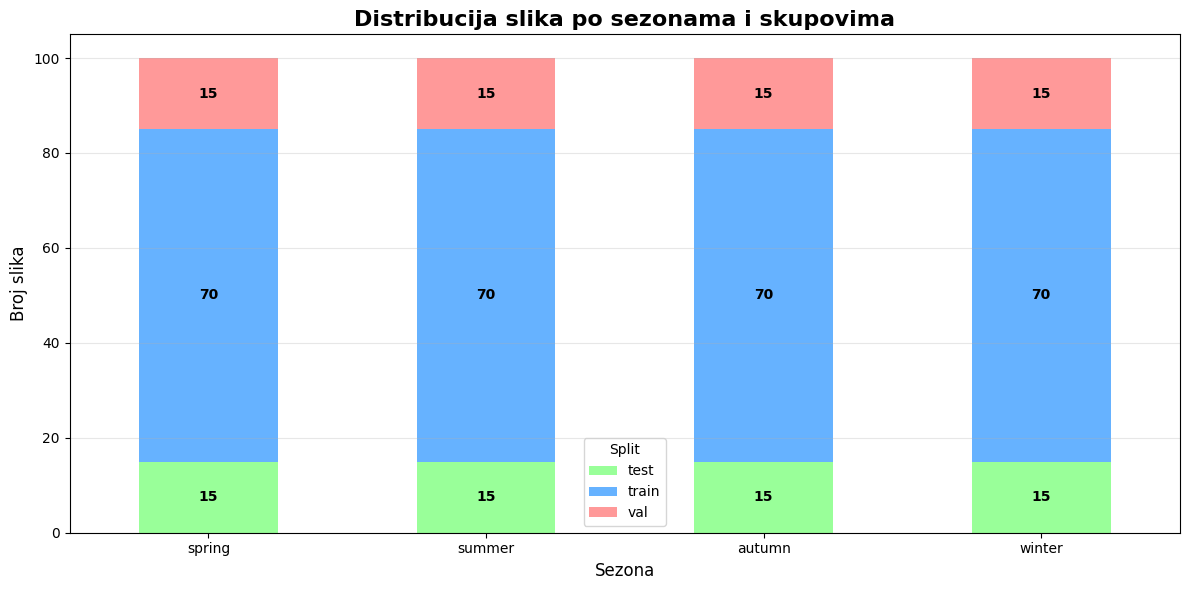

In [2]:
sezone = ['spring', 'summer', 'autumn', 'winter']
splits = ['train', 'val', 'test']

statistika = []
for split in splits:
    for sezona in sezone:
        path = f"data/{split}/{sezona}"
        if os.path.exists(path):
            broj = len(os.listdir(path))
            statistika.append({
                'split': split, 
                'sezona': sezona, 
                'broj_slika': broj
            })

df = pd.DataFrame(statistika)
print("STATISTIKA DATASET-A")
print("="*50)
print(df.to_string(index=False))
print("="*50)


ukupno = df['broj_slika'].sum()
print(f"\nUkupan broj slika: {ukupno}")


prosek_po_sezoni = df.groupby('sezona')['broj_slika'].sum().mean()
print(f"Prosečno slika po sezoni: {prosek_po_sezoni:.0f}")

print("\nUkupno po splitovima:")
for split in splits:
    ukupno_split = df[df['split'] == split]['broj_slika'].sum()
    print(f"  {split}: {ukupno_split} slika")

print("\nBalansiranost klasa:")
for sezona in sezone:
    ukupno_sezona = df[df['sezona'] == sezona]['broj_slika'].sum()
    print(f"  {sezona}: {ukupno_sezona} slika")

plt.figure(figsize=(12, 6))

pivot_df = df.pivot(index='sezona', columns='split', values='broj_slika')

pivot_df = pivot_df.reindex(['spring', 'summer', 'autumn', 'winter'])

colors = {'train': '#66B2FF', 'val': '#FF9999', 'test': '#99FF99'}
pivot_df.plot(kind='bar', stacked=True, color=[colors[c] for c in pivot_df.columns], figsize=(12, 6))

plt.title('Distribucija slika po sezonama i skupovima', fontsize=16, fontweight='bold')
plt.xlabel('Sezona', fontsize=12)
plt.ylabel('Broj slika', fontsize=12)
plt.legend(title='Split')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)


for i, sezona in enumerate(pivot_df.index):
    cumulative = 0
    for split in pivot_df.columns:
        value = pivot_df.loc[sezona, split]
        plt.text(i, cumulative + value/2, str(value), 
                ha='center', va='center', fontweight='bold')
        cumulative += value

plt.tight_layout()
plt.show()

## Primeri slika iz svake sezone

S obzirom da ne postoje gotove oznake, svaka slika je ručno klasifikovana na osnovu dosadašnjeg iskustva, pročitane literature i ličnog osećaja. Neke karakterisitike koje su se gledale i na osnovu kojih je moguće odrediti godišnje doba su:

🌸 **Proleće** – rumenija koža, svetlija kosa i svetlije oči  
☀️ **Leto** – bleda koža, svetle oči, ponekad pepeljasta kosa  
🍂 **Jesen** – žućkast ten, često crvenkasta ili riđa kosa  
❄️ **Zima** – tamnija koža, tamna kosa i tamne oči  


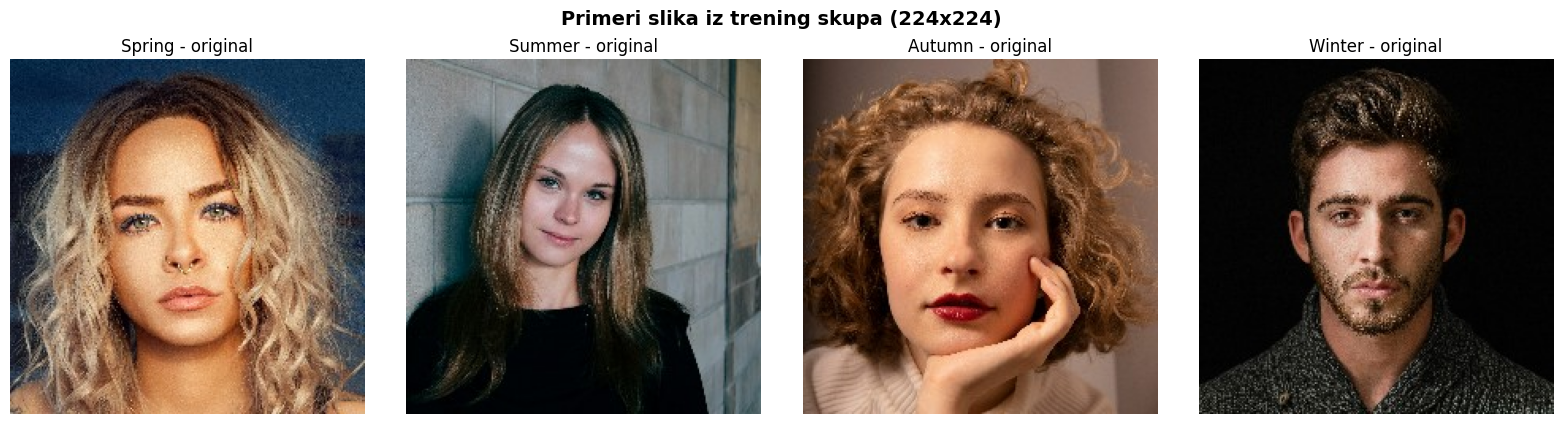

In [3]:
plt.figure(figsize=(16, 8))

for i, sezona in enumerate(['spring', 'summer', 'autumn', 'winter']):

    train_path = f"data/train/{sezona}"
    if os.path.exists(train_path) and len(os.listdir(train_path)) > 0:
        img_name = os.listdir(train_path)[0]
        img_path = f"{train_path}/{img_name}"
        
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, 4, i+1)
        plt.imshow(img_rgb)
        plt.title(f'{sezona.capitalize()} - original', fontsize=12)
        plt.axis('off')
        

plt.suptitle('Primeri slika iz trening skupa (224x224)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## FaceExtractor - Izdvajanje regiona lica

Za potrebe projekta razvijena je klasa `FaceExtractor` koja koristi **MediaPipe Face Mesh** za detekciju 468 ključnih tačaka na licu. Na osnovu ovih tačaka izdvajaju se regioni:

- **Koža lica** - formiranjem ovala lica i uklanjanjem očiju i usana
- **Oči** - pojedinačno levo i desno oko
- **Kosa** - procena regiona iznad čela

### Performanse izdvajanja
- **Koža i oči** - izdvajaju se vrlo precizno
- **Kosa** - izdvajanje je slabije i predstavlja izazov (varijacije u frizurama, bojama, pozadini)

Izdvojeni regioni će se koristiti za treniranje CNN modela kako bi se ispitalo da li specijalizovani regioni (koža, kosa, oči) mogu poboljšati klasifikaciju sezonskih tipova u odnosu na modele trenirane na celoj slici.

FaceExtractor kreiran
 Lice detektovano
   - Piksela kože: 7333
   - Piksela kose: 2230
   - Levo oko: (17, 31, 3)
   - Desno oko: (17, 30, 3)


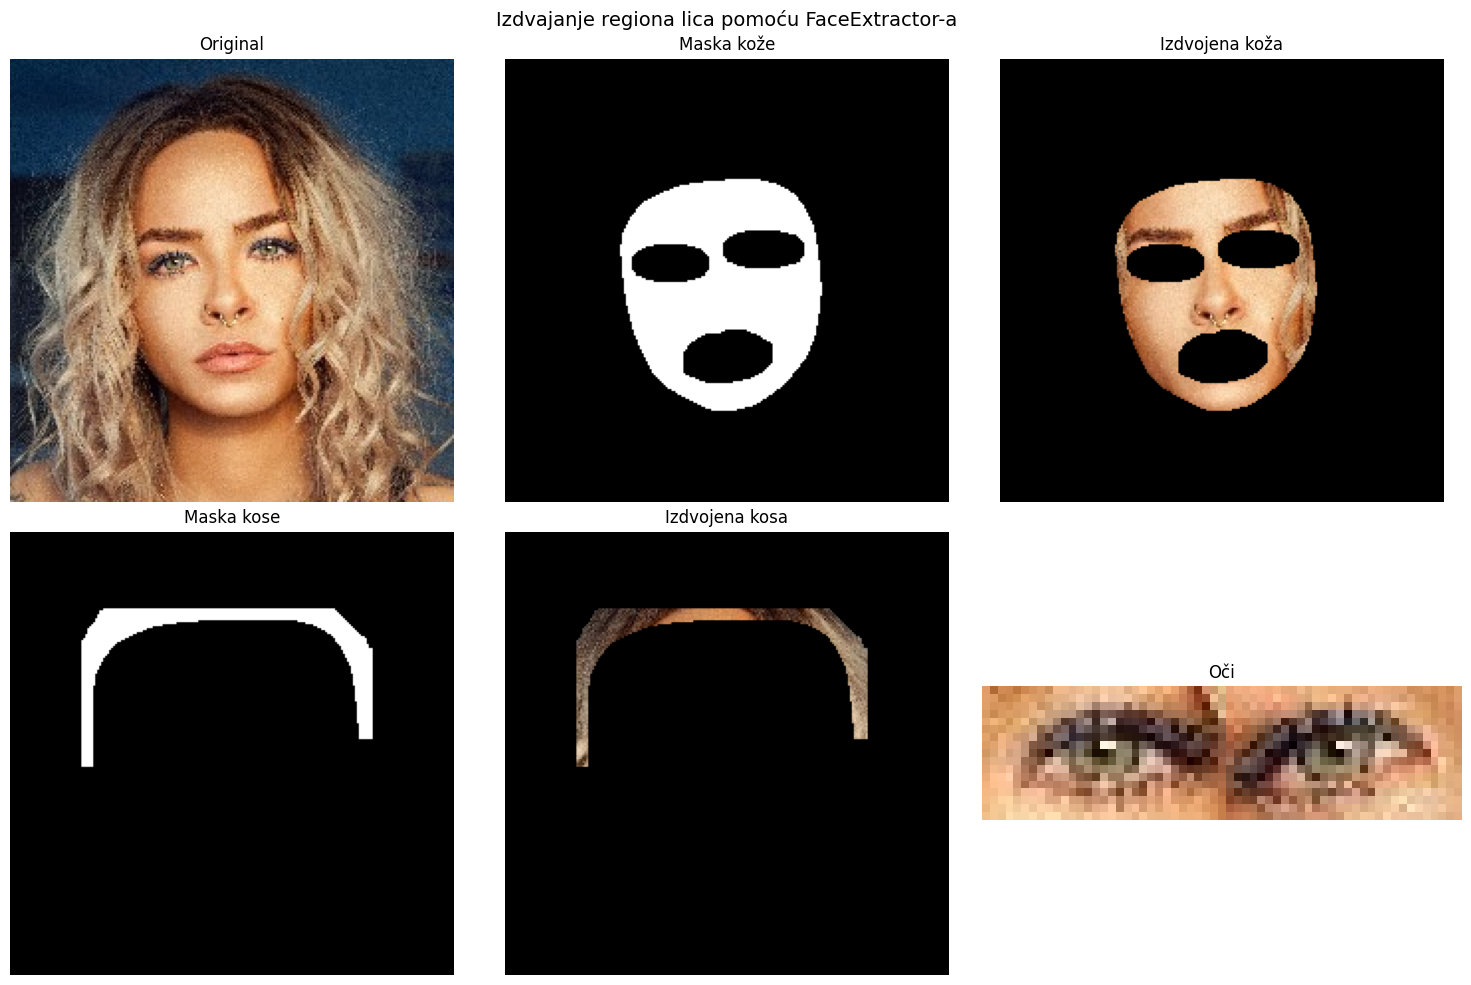

In [4]:
extractor = FaceExtractor()
print("FaceExtractor kreiran")

test_path = "data/train/spring/" + os.listdir("data/train/spring")[0]
result = extractor.extract_features(test_path, visualize=False)

if result:
    print(f" Lice detektovano")
    print(f"   - Piksela kože: {len(result['skin_pixels'])}")
    print(f"   - Piksela kose: {len(result['hair_pixels'])}")
    print(f"   - Levo oko: {result['left_eye'].shape}")
    print(f"   - Desno oko: {result['right_eye'].shape}")
    
if result:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    

    axes[0, 0].imshow(cv2.cvtColor(result['original_image'], cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
   
    axes[0, 1].imshow(result['skin_mask'], cmap='gray')
    axes[0, 1].set_title('Maska kože')
    axes[0, 1].axis('off')
    
   
    skin_only = cv2.bitwise_and(result['original_image'], result['original_image'], mask=result['skin_mask'])
    axes[0, 2].imshow(cv2.cvtColor(skin_only, cv2.COLOR_BGR2RGB))
    axes[0, 2].set_title('Izdvojena koža')
    axes[0, 2].axis('off')
    
  
    axes[1, 0].imshow(result['hair_mask'], cmap='gray')
    axes[1, 0].set_title('Maska kose')
    axes[1, 0].axis('off')
    
    
    hair_only = cv2.bitwise_and(result['original_image'], result['original_image'], mask=result['hair_mask'])
    axes[1, 1].imshow(cv2.cvtColor(hair_only, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title('Izdvojena kosa')
    axes[1, 1].axis('off')
    
   
    if result['left_eye'].size > 0 and result['right_eye'].size > 0:
        left = result['left_eye']
        right = result['right_eye']

        
        target_h = min(left.shape[0], right.shape[0])
        if left.shape[0] != target_h:
            new_w = int(left.shape[1] * target_h / left.shape[0])
            left = cv2.resize(left, (new_w, target_h))
        if right.shape[0] != target_h:
            new_w = int(right.shape[1] * target_h / right.shape[0])
            right = cv2.resize(right, (new_w, target_h))

        combined_eyes = np.hstack([left, right])
        axes[1, 2].imshow(cv2.cvtColor(combined_eyes, cv2.COLOR_BGR2RGB))
        axes[1, 2].set_title('Oči')
        axes[1, 2].axis('off')
    
    plt.suptitle('Izdvajanje regiona lica pomoću FaceExtractor-a', fontsize=14)
    plt.tight_layout()
    plt.show()

## Generisanje skupa podataka sa isečenim licem korišćenjem FaceExtractor-a

U cilju poboljšanja robusnosti modela i smanjenja uticaja pozadine, uveden je dodatni korak pretprocesiranja pre treniranja neuronske mreže. U ovom koraku koristi se klasa `FaceExtractor`, zasnovana na MediaPipe Face Mesh modelu, za generisanje standardizovanog i konzistentno uokvirenog skupa podataka.

### Cilj

Cilj ovog postupka je da se:

- Standardizuje pozicija i veličina lica na svim slikama  
- Smanji uticaj pozadine  
- Obezbedi konzistentna skala i centriranje lica  
- Poboljša generalizacija CNN modela  

---

### Tok obrade

Za svaku sliku u direktorijumu primenjuju se sledeći koraci:

1. **Detekcija facijalnih markera (landmarka)**  
   - MediaPipe Face Mesh detektuje 468 tačaka na licu.  
   - Koordinate su normalizovane u odnosu na dimenzije slike.

2. **Računanje ograničavajućeg pravougaonika (bounding box)**  
   - Izračunavaju se minimalne i maksimalne x i y koordinate svih landmarka:
     - `x_min`, `x_max`
     - `y_min`, `y_max`
   - Time se dobija pravougaonik koji obuhvata celo lice.

3. **Proširenje pravougaonika**  
   - Pravougaonik se proširuje za 20% (`pad = 0.20`)  
   - Time se uključuju i linija kose i vilica.

4. **Isecanje lica**  
   - Slika se seče prema proširenom bounding box-u.

5. **Promena dimenzije (resize)**  
   - Isečena slika lica se skalira na dimenzije `224 × 224` piksela.  
   - Ova rezolucija odgovara ulaznim dimenzijama MobileNetV3 modela.

6. **Čuvanje obrađene slike**  
   - Slika se snima u novi direktorijum:



---

### Značaj ovog koraka

Iako su originalne slike uglavnom već centrirane, one mogu da se razlikuju po:

- Udaljenosti lica od kamere  
- Zumiranju  
- Količini pozadine  
- Odnosu veličine lica i cele slike  

Standardizacijom isečenog lica:

- Model se fokusira na kolorističke karakteristike lica  
- Smanjuje se uticaj pozadinskih elemenata  
- Trening postaje stabilniji  
- Smanjuje se konfuzija između sličnih sezona (npr. Autumn i Spring)

---

### Rezultat

Dobijen je novi skup podataka.


Svaka slika:

- Sadrži standardizovan isečak lica  
- Ima identične dimenzije (224×224)  
- Zadržava istu klasnu strukturu kao originalni skup  

Ovaj obrađeni skup podataka koristi se kao ulaz za treniranje MobileNetV3 modela.


## Treniranje MobileNetV3 modela nad “face-cropped” skupom podataka (`data_face/`)

Nakon što je pomoću `FaceExtractor` klase generisan novi skup slika sa konzistentno isečenim i skaliranim licem (npr. `data_face/train|val|test/{spring,summer,autumn,winter}`), sledeći korak je treniranje CNN modela nad tim skupom.

### Ideja
- Umesto originalnih slika (koje mogu imati različitu količinu pozadine i različit odnos “lice : okvir”), koristi se skup slika gde je lice uvek u sličnom položaju i približno iste veličine.
- Očekivani efekat je stabilniji trening i potencijalno bolja generalizacija, posebno kod klasa koje se često mešaju (npr. *Autumn* i *Spring*).

### Šta radi skripta `train_extracted.py`?
1. Učitava skup slika iz `data_face/` (train/val/test).
2. Primeni standardne transformacije i augmentacije (flip, mala rotacija, blagi jitter osvetljenja/kontrasta).
3. Koristi MobileNetV3-Large (pretrained na ImageNet) i menja poslednji sloj na 4 klase.
4. Treniranje na train skupu, izbor najboljeg modela po `val_acc`.
5. Evaluacija na test skupu: Confusion Matrix + Classification Report.

> Napomena: Pošto je trening na CPU, koristi se manji `BATCH_SIZE` i konzervativan broj epoha.

## Podešavanje početnih parametara i skupa podataka za treniranje, testiranje i validaciju

In [5]:
DATA_DIR = "data_face"   
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 15
LR = 3e-4
NUM_CLASSES = 4
DEVICE = "cpu"
NUM_WORKERS = 4

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

def main():
    print("Using device:", DEVICE)
    print("Training folder:", DATA_DIR)

## Učitavanje podataka

In [6]:
train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_tfms)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=val_tfms)

if len(train_ds.classes) != NUM_CLASSES:
    raise ValueError(f"Expected {NUM_CLASSES} classes, got {len(train_ds.classes)}: {train_ds.classes}")

print("Classes:", train_ds.classes)
print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=False
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=False
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=False
)

Classes: ['autumn', 'spring', 'summer', 'winter']
Train: 277 | Val: 57 | Test: 59


## Podešavanje parametara modela

In [7]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_val_acc = 0.0
best_path = "best_model_extracted.pth"


## Treniranje modela

In [8]:
for epoch in range(EPOCHS):
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        preds = outputs.argmax(1)
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_acc = train_correct / train_total
    train_loss /= train_total


    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            loss = criterion(outputs, y)

            val_loss += loss.item() * x.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_acc = val_correct / val_total
    val_loss /= val_total

    print(f"\nEpoch {epoch+1}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f"Saved new best model -> {best_path}")

Epoch 1/15: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]



Epoch 1:
Train Loss: 1.3435 | Train Acc: 0.3105
Val   Loss: 1.2500 | Val   Acc: 0.4561
Saved new best model -> best_model_extracted.pth


Epoch 2/15: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]



Epoch 2:
Train Loss: 0.9720 | Train Acc: 0.6390
Val   Loss: 0.8996 | Val   Acc: 0.7895
Saved new best model -> best_model_extracted.pth


Epoch 3/15: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]



Epoch 3:
Train Loss: 0.6479 | Train Acc: 0.7509
Val   Loss: 0.8391 | Val   Acc: 0.5965


Epoch 4/15: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]



Epoch 4:
Train Loss: 0.4436 | Train Acc: 0.8303
Val   Loss: 0.7810 | Val   Acc: 0.7193


Epoch 5/15: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]



Epoch 5:
Train Loss: 0.2689 | Train Acc: 0.9061
Val   Loss: 0.8331 | Val   Acc: 0.6491


Epoch 6/15: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]



Epoch 6:
Train Loss: 0.1796 | Train Acc: 0.9567
Val   Loss: 1.0665 | Val   Acc: 0.6491


Epoch 7/15: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]



Epoch 7:
Train Loss: 0.1752 | Train Acc: 0.9242
Val   Loss: 0.9804 | Val   Acc: 0.6140


Epoch 8/15: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]



Epoch 8:
Train Loss: 0.1934 | Train Acc: 0.9350
Val   Loss: 0.6812 | Val   Acc: 0.7368


Epoch 9/15: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]



Epoch 9:
Train Loss: 0.1082 | Train Acc: 0.9639
Val   Loss: 0.6807 | Val   Acc: 0.7544


Epoch 10/15: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]



Epoch 10:
Train Loss: 0.0915 | Train Acc: 0.9675
Val   Loss: 0.8372 | Val   Acc: 0.7193


Epoch 11/15: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]



Epoch 11:
Train Loss: 0.0871 | Train Acc: 0.9711
Val   Loss: 1.4155 | Val   Acc: 0.5965


Epoch 12/15: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]



Epoch 12:
Train Loss: 0.1998 | Train Acc: 0.9278
Val   Loss: 1.0176 | Val   Acc: 0.6316


Epoch 13/15: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]



Epoch 13:
Train Loss: 0.1281 | Train Acc: 0.9458
Val   Loss: 0.8598 | Val   Acc: 0.7544


Epoch 14/15: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]



Epoch 14:
Train Loss: 0.2083 | Train Acc: 0.9314
Val   Loss: 1.0361 | Val   Acc: 0.6842


Epoch 15/15: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]



Epoch 15:
Train Loss: 0.1644 | Train Acc: 0.9495
Val   Loss: 0.9704 | Val   Acc: 0.5789


## Evaluacija

In [9]:
print("\n=== Testing Best Model (Face-Cropped Dataset) ===")
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        outputs = model(x)
        preds = outputs.argmax(1).cpu().numpy()

        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_ds.classes))


=== Testing Best Model (Face-Cropped Dataset) ===


C:\Users\katar\AppData\Local\Temp\ipykernel_17160\2255592486.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=DEV


Confusion Matrix:
[[ 9  2  1  3]
 [ 1  7  5  2]
 [ 2  4  8  1]
 [ 1  0  0 13]]

Classification Report:
              precision    recall  f1-score   support

      autumn       0.69      0.60      0.64        15
      spring       0.54      0.47      0.50        15
      summer       0.57      0.53      0.55        15
      winter       0.68      0.93      0.79        14

    accuracy                           0.63        59
   macro avg       0.62      0.63      0.62        59
weighted avg       0.62      0.63      0.62        59



## Graficki prikaz rezultata

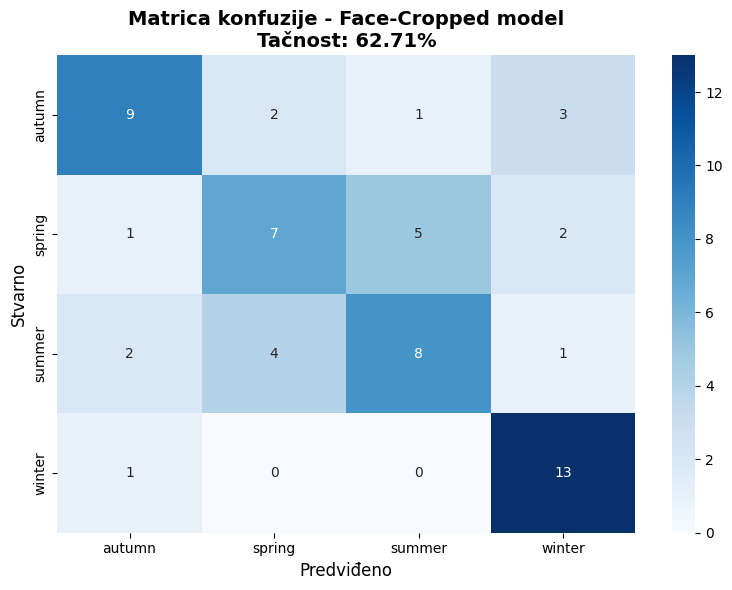

In [12]:
# VIZUELIZACIJA REZULTATA - Matrica konfuzije
# ====================================================
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Uzima poslednju matricu konfuzije koju si dobila
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes)
plt.title(f'Matrica konfuzije - Face-Cropped model\nTačnost: {np.trace(cm)/np.sum(cm):.2%}', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predviđeno', fontsize=12)
plt.ylabel('Stvarno', fontsize=12)
plt.tight_layout()
plt.show()

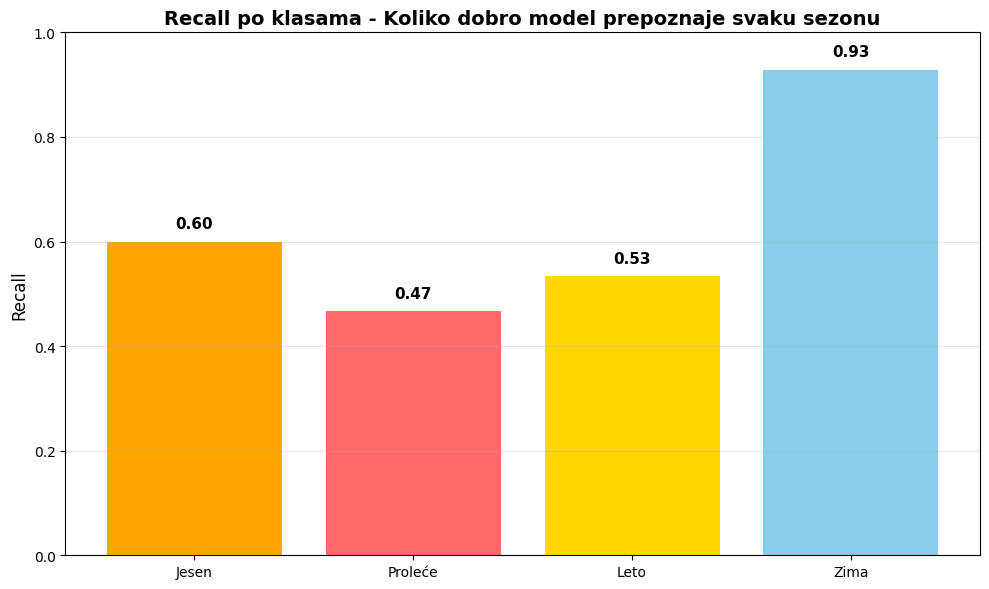

In [13]:
# RECALL PO KLASAMA
# ====================================================
from sklearn.metrics import recall_score

recall = recall_score(y_true, y_pred, average=None)
klase = train_ds.classes
klase_lepse = ['Jesen', 'Proleće', 'Leto', 'Zima']  

plt.figure(figsize=(10, 6))
bars = plt.bar(klase_lepse, recall, color=['#FFA500', '#FF6B6B', '#FFD700', '#87CEEB'])
plt.ylabel('Recall', fontsize=12)
plt.title('Recall po klasama - Koliko dobro model prepoznaje svaku sezonu', 
          fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)

# Dodaje vrednosti
for bar, r in zip(bars, recall):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
             f'{r:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

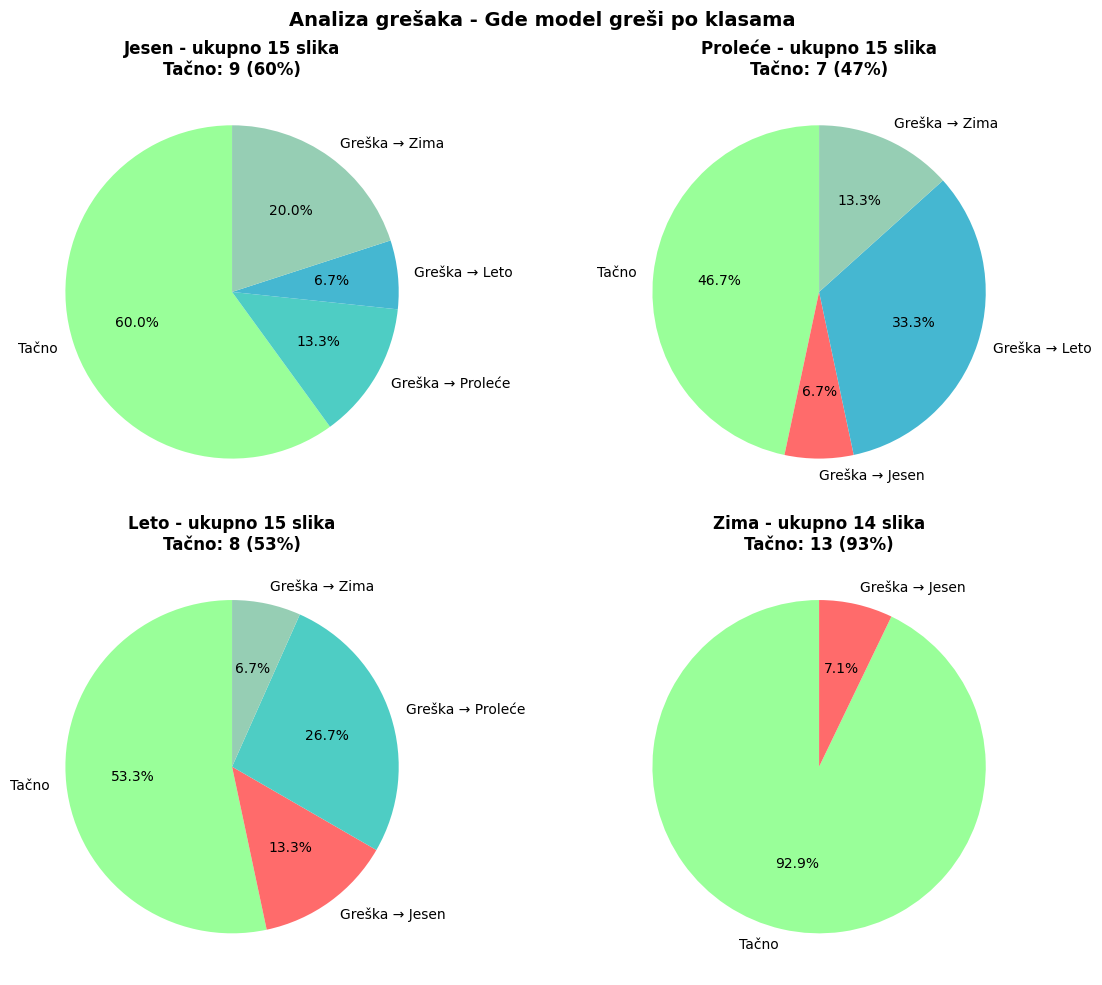

In [14]:
# ====================================================
# ANALIZA GREŠAKA - Gde model greši
# ====================================================
cm = confusion_matrix(y_true, y_pred)
klase_lepse = ['Jesen', 'Proleće', 'Leto', 'Zima']
boje_greske = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, (ax, klasa) in enumerate(zip(axes.flatten(), klase_lepse)):
    ukupno = cm[i, :].sum()
    tacni = cm[i, i]
    
    # Pronađi gde greši
    labels = ['Tačno']
    sizes = [tacni]
    colors = ['#99FF99']
    
    for j in range(4):
        if j != i and cm[i, j] > 0:
            labels.append(f'Greška → {klase_lepse[j]}')
            sizes.append(cm[i, j])
            colors.append(boje_greske[j])
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'{klasa} - ukupno {ukupno} slika\nTačno: {tacni} ({tacni/ukupno:.0%})', fontweight='bold')

plt.suptitle('Analiza grešaka - Gde model greši po klasama', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Zaključak
Na osnovu dobijene matrice konfuzije može se zaključiti sledeće:

Zima se najbolje prepoznaje (13/15 tačno) – model vrlo uspešno identifikuje osobe zimskog tipa, verovatno zbog izražene tamne kose i tamnijeg tena.

Leto i jesen imaju solidne rezultate (8/15 i 9/15 tačno), ali se javljaju određena preklapanja – jesen se najčešće meša sa zimom (3 slike), a leto sa prolećem.

Proleće je najveći izazov (7/15 tačno) – najčešće biva pogrešno klasifikovano kao leto, što je očekivano s obzirom na sličnost svetlijih tonova u ove dve sezone.

Ukupna tačnost modela iznosi 62% (37/60), što je solidan rezultat za zadatak sa 4 klase i relativno mali dataset